In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [4]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [5]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [6]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [7]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 39) (215352, 30) (215352, 15) (215352, 15) (215352, 15) (215352, 15) (215352,)
(53838, 39) (53838, 30) (53838, 15) (53838, 15) (53838, 15) (53838, 15) (53838,)
(67298, 39) (67298, 30) (67298, 15) (67298, 15) (67298, 15) (67298, 15) (67298,)


# Train

In [8]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*8)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [10]:
pep = tf.keras.layers.Input(shape=((30,)))
input1 = tf.keras.layers.Embedding(21, 64, input_length=30, mask_zero=True)(pep)

input2 = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
input3 = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(n)

c = tf.keras.layers.Input(shape=((15,)))
input4 = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(c)

m1 = tf.keras.layers.Input(shape=((15,)))
input5 = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m1)

m2 = tf.keras.layers.Input(shape=((15,)))
input6 = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m2)
# CNN add??
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(64, activation='relu')(lstm1)

net_dense1 = tf.keras.layers.Dense(64, activation='relu')(input2)

digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input3)
net_n_ = tf.keras.layers.Dense(32, activation='relu')(digest_n)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n_)

digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input4)
net_c_ = tf.keras.layers.Dense(32, activation='relu')(digest_c)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c_)

digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input5)
net_m1_ = tf.keras.layers.Dense(32, activation='relu')(digest_m1)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m1_)

digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input6)
net_m2_ = tf.keras.layers.Dense(32, activation='relu')(digest_m2)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m2_)

merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                    net_n,
                                    net_c,
                                    net_m1,
                                    net_m2])

net1 = tf.keras.layers.Dense(128, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net1)
net3 = tf.keras.layers.Dense(64, activation='relu')(net1_drop)
# net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net1)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3)

model_high = tf.keras.Model(inputs=[pep, input2,
                              n, c,
                              m1, m2],
                       outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [11]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=32,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
6730/6730 [==============================] - 603s 85ms/step - loss: 0.8251 - accuracy: 0.7430 - val_loss: 0.4345 - val_accuracy: 0.8201
Epoch 2/300
6730/6730 [==============================] - 543s 81ms/step - loss: 0.4032 - accuracy: 0.8199 - val_loss: 0.3915 - val_accuracy: 0.8268
Epoch 3/300
6730/6730 [==============================] - 552s 82ms/step - loss: 0.3866 - accuracy: 0.8273 - val_loss: 0.3846 - val_accuracy: 0.8289
Epoch 4/300
6730/6730 [==============================] - 552s 82ms/step - loss: 0.3792 - accuracy: 0.8304 - val_loss: 0.3833 - val_accuracy: 0.8306
Epoch 5/300
6730/6730 [==============================] - 557s 83ms/step - loss: 0.3762 - accuracy: 0.8326 - val_loss: 0.3780 - val_accuracy: 0.8336
Epoch 6/300
6730/6730 [==============================] - 591s 88ms/step - loss: 0.3694 - accuracy: 0.8352 - val_loss: 0.3800 - val_accuracy: 0.8340
Epoch 7/300
6730/6730 [==============================] - 601s 89ms/step - loss: 0.3658 - accuracy: 0.8369 - val_

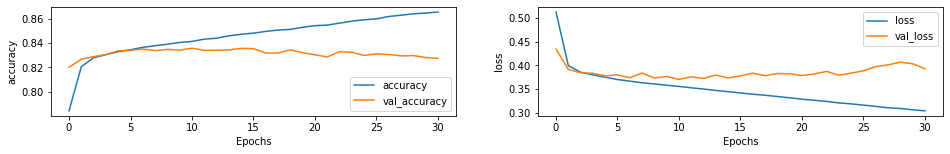

In [12]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2104/2104 [==============================] - 42s 20ms/step - loss: 0.3911 - accuracy: 0.8284
Test Loss: 0.3910985291004181
Test Accuracy: 0.8284347057342529
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     33706
           1       0.84      0.80      0.82     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9079252834884934


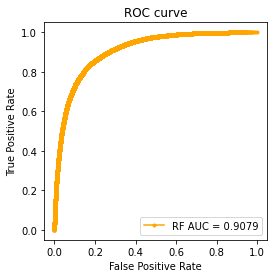

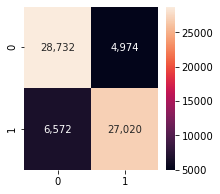

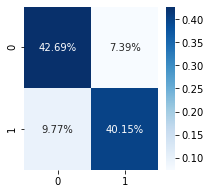

In [13]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# best

2104/2104 [==============================] - 38s 18ms/step - loss: 0.3654 - accuracy: 0.8372
Test Loss: 0.36536043882369995
Test Accuracy: 0.837201714515686
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     33706
           1       0.83      0.84      0.84     33592

    accuracy                           0.84     67298
   macro avg       0.84      0.84      0.84     67298
weighted avg       0.84      0.84      0.84     67298

rf auc : 0.9172036976095229


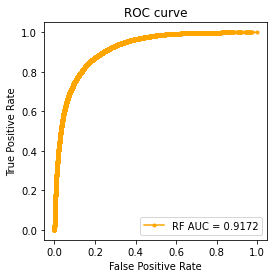

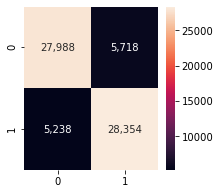

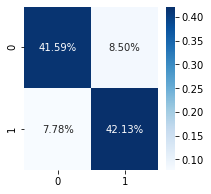

In [12]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# digestibility Embedding Go!
  - using pre trained protein language model